In [207]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

In [217]:
from IPython.display import display, clear_output
import random
class DynamicMazeTreasureHunt(gym.Env):
    def __init__(self):
        super(DynamicMazeTreasureHunt, self).__init__()

        # Define action and observation spaces, gym.space objects

        self.action_space = spaces.Discrete(6)

        #assuming each robot's field of view can contain up to 10 objects
        # each object is represented by a tuple (object_type, distance, angle)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,shape = (10,3))

        # Initialize state
        self.grid_size = (10,10)
        self.grid = np.zeros(self.grid_size)
        self.robot_position = (0,0)
        self.energy = 100
        self.treasure_positions = [(5,5)]
        self.trap_positions = [(3,3)]
        self.max_energy = 100
        self.heading = 0


        #initialize rewards
        self.treasure_reward = 100
        self.trap_reward = -100
        self.living_cost_reward = -1
        self.discovery_reward = 10

    def step(self, action):
        # Execute one time step within the environment

        # update robot position based on action
        if action == 0:  # up
            self.robot_position = (max(0, self.robot_position[0]-1), self.robot_position[1])
        elif action == 1:  # down
            self.robot_position = (min(self.grid_size[0]-1, self.robot_position[0]+1), self.robot_position[1])
        elif action == 2:  # left
            self.robot_position = (self.robot_position[0], max(0, self.robot_position[1]-1))
        elif action == 3:  # right
            self.robot_position = (self.robot_position[0], min(self.grid_size[1]-1, self.robot_position[1]+1))
        elif action == 4:  # turn right
            self.heading = (self.heading + 90) % 360
        elif action == 5:  # turn left
            self.heading = (self.heading - 90) % 360

        # decrease energy
        self.energy -= 1

        # check for treasure
        if self.robot_position in self.treasure_positions:
            self.energy = self.max_energy # replenish energy for reaching a treasure position
            reward = self.treasure_reward
        elif self.robot_position in self.trap_positions:
            self.energy -= 50 # decrease energy
            reward = self.trap_reward
        else:
            reward = self.living_cost_reward

        terminated = self.energy <= 0 #check if the episode is done, if the robot has run out of energy

        #update obersvation
        #TODO: Implement method to create observation based on current starte and partial observability
        observation = self.get_observation()


        info = {}

        return observation, reward, terminated, info
    
    def reset(self):
        # Reset the state of the environment to an initial state
        self.robot_position = (0,0)
        self.heading = 0
        self.energy = self.max_energy

        # Randomize positions of treasure and trap
        possible_positions = [(i, j) for i in range(self.grid_size[0]) for j in range(self.grid_size[1]) 
                            if (i, j) != self.robot_position]
        self.treasure_positions = [random.choice(possible_positions)]
        possible_positions.remove(self.treasure_positions[0])  # Remove treasure position from possible positions
        self.trap_positions = [random.choice(possible_positions)]

        return self.get_observation()

    
    from IPython.display import display, clear_output

    def render(self, mode='human'):
        if mode == 'human':
            clear_output(wait=True)  # Clear the previous image
            img = np.zeros(self.grid_size)  # This creates a 2D array of zeros with the same dimensions as the grid
            img[self.robot_position] = 1  # Set the robot position to 1
            for pos in self.treasure_positions:  # Set the treasure positions to 2
                img[pos] = 2
            for pos in self.trap_positions:  # Set the trap positions to 3
                img[pos] = 3
            plt.imshow(img)  # Create an image from the array
            plt.show()  # Display the image
            display(plt.gcf())  # Display the current figure
        elif mode == 'rgb_array':
            # For rgb_array mode, you would return the image as an RGB array
            # This is typically used for recording videos or other post-processing
            pass

    def get_observation(self):
        # Initialize an empty list for the objects in the field of view
        objects_in_view = []

        # Initialize list to keep track of obstructed views
        obstructed_angles = []

        # Iterate over each cell in the grid
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                # Calculate distance and angle to the cell from the robot's position
                distance = np.sqrt((i-self.robot_position[0])**2 + (j-self.robot_position[1])**2)
                angle = np.arctan2(j-self.robot_position[1], i-self.robot_position[0]) * 180 / np.pi
                angle_relative = (self.heading - angle) % 360
                
                # Check if the cell is in the field of view
                if 0 <= angle_relative <= 180:
                    # Calculate the angles to the corners of the cell
                    angles_to_corners = [np.arctan2(corner[1]-self.robot_position[1], corner[0]-self.robot_position[0]) * 180 / np.pi for corner in [(i, j), (i+1, j), (i, j+1), (i+1, j+1)]]
                    
                    # Calculate the min and max angle to the cell
                    min_angle, max_angle = min(angles_to_corners), max(angles_to_corners)
                    
                    # Check if the view to the cell is obstructed
                    if any(min_angle <= obstructed <= max_angle for obstructed in obstructed_angles):
                        continue
                        
                    # If the cell contains an object, add it to the list of objects in view and mark the view as obstructed
                    min_angle = int(min_angle) 
                    max_angle = int(max_angle)

                    if (i, j) in self.treasure_positions:
                        objects_in_view.append(('treasure', distance, angle_relative))
                        obstructed_angles.extend(range(min_angle, max_angle+1))
                    elif (i, j) in self.trap_positions:
                        objects_in_view.append(('trap', distance, angle_relative))
                        obstructed_angles.extend(range(min_angle, max_angle+1))

        # If there are less than 10 objects in view, pad the list with 'empty' objects
        while len(objects_in_view) < 10:
            objects_in_view.append(('empty', 0.0, 0.0))

        # Convert the list of objects in view to a numpy array and return it
        return np.array(objects_in_view, dtype=[('object_type', 'U10'), ('distance', float), ('angle', float)])

In [209]:
import torch
import torch.nn as nn

class LSTMDQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMDQN, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(1, self.hidden_dim),
                torch.zeros(1, self.hidden_dim))

    def forward(self, x):
        x, new_hidden = self.lstm(x.view(len(x), -1), self.hidden)
        self.hidden = (new_hidden[0].detach(), new_hidden[1].detach())
        x = self.fc(x.view(len(x), -1))
        return x
    
    def reset_hidden(self):
        self.hidden = self.init_hidden()

In [210]:
import torch.optim as optim

class Agent:
    def __init__(self, input_dim, hidden_dim, output_dim, action_space_n):
        self.model = LSTMDQN(input_dim, hidden_dim, output_dim)
        self.optimizer = optim.Adam(self.model.parameters())
        self.criterion = nn.MSELoss()
        self.action_space_n = action_space_n
        self.gamma = 0.9

    def choose_action(self, state, epsilon):

        # convert state to state_tensor
        object_type_dict = {'empty': 0, 'treasure': 1, 'trap': 2}
        state_numerical = np.array([[object_type_dict[obj['object_type']], obj['distance'], obj['angle']] for obj in state])
        state_flat = state_numerical.flatten().astype(float)
        state_tensor = torch.from_numpy(state_flat).float().view(1, -1)


        if np.random.random() < epsilon:
            return np.random.choice(a=range(self.action_space_n))
        else:
            with torch.no_grad():
                return torch.argmax(self.model(state_tensor)).item()

    def update(self, state, action, reward, next_state):

        # Assuming that an 'empty' object is represented by (0, 0.0, 0.0) for (object_type, distance, angle)
        # where object_type for 'empty' is 0, 'treasure' is 1, and 'trap' is 2
        object_type_dict = {'empty': 0, 'treasure': 1, 'trap': 2}

        # Convert structured array to a regular array with numerical data only
        state_numerical = np.array([[object_type_dict[obj['object_type']], obj['distance'], obj['angle']] for obj in state])
        next_state_numerical = np.array([[object_type_dict[obj['object_type']], obj['distance'], obj['angle']] for obj in next_state])

        # Flatten the array and convert to float
        state_flat = state_numerical.flatten().astype(float)
        next_state_flat = next_state_numerical.flatten().astype(float)

        # Convert to PyTorch tensors
        state_tensor = torch.from_numpy(state_flat).float().view(1, -1)
        next_state_tensor = torch.from_numpy(next_state_flat).float().view(1, -1)
        expected_reward = self.model(state_tensor)[0][action] + reward + self.model(next_state_tensor).max(1)[0].detach()

        # Get the current Q-values for all actions
        current_q_values = self.model(state_tensor)

        # Get the Q-value for the action taken
        current_q_value = current_q_values[0][action]

        # Calculate the target Q-value
        next_q_values = self.model(next_state_tensor)
        max_next_q_value = next_q_values.max(1)[0].detach()
        expected_q_value = reward + (self.gamma * max_next_q_value)  # assuming gamma is your discount factor

        # calculate loss - the target Q-value should be detached from the graph as it's a target
        loss = self.criterion(current_q_value, expected_q_value.unsqueeze(0))

        # backpropagate loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.model.reset_hidden()  # Reset the hidden state after backpropagation

In [220]:
def train(agent, env, episodes, epsilon_decay):
    epsilon = 1.0
    for episode in range(episodes):
        print(episode)
        state = env.reset()
        agent.model.reset_hidden()  # Reset the hidden state at the start of each episode
        done = False
        while not done:
            action = agent.choose_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            #env.render() # Comment out if no render
        epsilon *= epsilon_decay


In [221]:
# Initialize the environment        
env = DynamicMazeTreasureHunt()

# Initialize the agent
input_dim = 30 # 10 objects * 3 attributes per object
hidden_dim = 64 # arbitrary number for the hidden dimensions
output_dim = env.action_space.n # number of available actions
agent = Agent(input_dim, hidden_dim, output_dim, env.action_space.n)

# Train the agent
episodes = 1000
epsilon_decay = 0.99
train(agent, env, episodes, epsilon_decay)
torch.save(agent.model.state_dict(), 'lstm_dqn_model.pth')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9


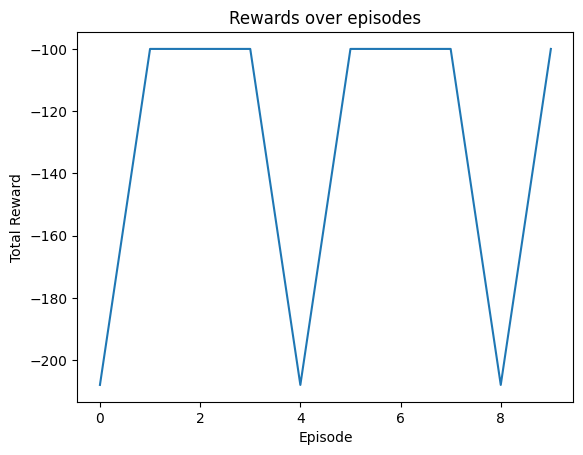

In [225]:
model = LSTMDQN(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('lstm_dqn_model.pth'))
model.eval()  # Set the model to evaluation mode

def evaluate(agent, env, episodes):
    total_rewards = []
    for episode in range(episodes):
        print(episode)
        state = env.reset()
        agent.model.reset_hidden()  # Reset the hidden state at the start of each episode
        done = False
        total_reward = 0
        while not done:
            action = agent.choose_action(state, epsilon=0)  # No randomness, choose best action
            state, reward, done, _ = env.step(action)
            total_reward += reward
            #env.render()
        total_rewards.append(total_reward)
    return total_rewards

import matplotlib.pyplot as plt

# Evaluate the model
rewards = evaluate(agent, env, episodes=10)  # Evaluate for a certain number of episodes

# Plot the rewards
plt.plot(rewards)
plt.title('Rewards over episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()